+ [VGGFace2](https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/)

+ [Haar Classification](https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/)

# Dependencies

In [ ]:
!pip install opencv-python

# https://github.com/nficano/pytube
# https://github.com/get-pytube/pytube3
# !pip install pytube3 --upgrade
# !pip install pytube --upgrade
!pip install --upgrade youtube-dl

# http://ffmpeg.org/download.html
!apt-get install ffmpeg

# https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c
# https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
#!pip install mtcnn

#!curl -Lo haarcascade_frontalface_default.xml \
#      https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml


# single shot multibox detector
# see https://github.com/opencv/opencv_extra/blob/4.4.0/testdata/dnn/download_models.py
# see https://github.com/opencv/opencv_3rdparty/tree/dnn_samples_face_detector_20180205_fp16
PATH_DDN_MODEL = "res10_300x300_ssd_iter_140000.caffemodel"
!curl -Lo \
        $PATH_DDN_MODEL \
        "https://github.com/opencv/opencv_3rdparty/blob/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel?raw=true"
        # "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel?raw=true"

# https://github.com/opencv/opencv/blob/4.4.0/samples/dnn/face_detector/deploy.prototxt
PATH_DDN_MODEL_CONFIG = "deploy.prototxt"
!curl -Lo \
        $PATH_DDN_MODEL_CONFIG \
        "https://raw.githubusercontent.com/opencv/opencv/4.4.0/samples/dnn/face_detector/deploy.prototxt"


     |████████████████████████████████| 1.8MB 2.8MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0    492      0 --:--:-- --:--:-- --:--:--   493
100   208  100   208    0     0    196      0  0:00:01  0:00:01 --:--:--  203k
100 5225k  100 5225k    0     0  2537k      0  0:00:02  0:00:02 --:--:-- 13.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28104  100 28104    0     0  65206      0 --:--:-- --:--:-- --:--:-- 65206


In [ ]:
# !youtube-dl -o "tmp2.mp4" http://youtube.com/watch?v=_4zeNNSManE

# Faces extraction

+ [Towards DataScience | Face Detection Models: Which to Use and Why?](https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c)

+ [GitHub | OpenCV deep learning module samples](https://github.com/opencv/opencv/tree/master/samples/dnn)

In [ ]:
def getDNNFacesFromBGRMatrix(bgrMatrix=[],
                              path_prefix= "",
                              debug=False):
    # https://github.com/opencv/opencv/tree/master/samples/dnn
    # https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV
    # https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c
    
    if len(bgrMatrix) <= 0:
        return []
    boxes = []
    facesBRGMatrices = []

    import cv2
    import numpy as np

    if debug:
      print('bgrMatrix', bgrMatrix.shape)

    h, w = bgrMatrix.shape[:2]

    if debug:
      print(f"height: {h}, width: {w}")

    # https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
    blob = cv2.dnn.blobFromImage(
                cv2.resize(bgrMatrix, (300, 300)),
                1.0,
                (300, 300),
                (104.0, 117.0, 123.0),
                # crop=False,
                # swapRB=True
            )
    net = cv2.dnn.readNetFromCaffe(
                        PATH_DDN_MODEL_CONFIG,
                        PATH_DDN_MODEL
                    )
    net.setInput(blob)
    faces = net.forward()
    if debug:
      print(f"faces detected: {len(faces)}")
      print(f"faces.shape: {faces.shape[2]}")

    for i in range(faces.shape[2]):
        confidence = faces[0, 0, i, 2]
        # if debug:
        #   print(f"confidence: {confidence}")
        if confidence > 0.5:
          if debug:
            print(f"confidence: {confidence}")
          box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
          (x, y, x1, y1) = box.astype("int")

          boxes.append((x, y, x1, y1))
          facesBRGMatrices.append(bgrMatrix[y:y1, x:x1])
          
          if debug:
            cv2.imwrite(f"{path_prefix}-face-{i}.png", bgrMatrix[y:y1, x:x1])
            cv2.rectangle(bgrMatrix, (x, y), (x1, y1), (0, 0, 255), 2)
    if debug:
        print(f'Saving {path_prefix}-detection.png')
        cv2.imwrite(f"{path_prefix}-detection.png" , bgrMatrix)
      
    return [ boxes, facesBRGMatrices ]

# getDNNFacesFromBGRMatrix(
#               bgrMatrix= mapImageFileToBGRMatrix('003-2.bmp'),
#               path_prefix= f"{PERSON_A_DATASET}/",
#               debug=True
#   )

---

## Helper functions

### DataURI to Image bytes

In [ ]:
def mapDataURIToImage(base64_string):
  from base64 import b64decode

  return b64decode(base64_string)

### Image to BGR matrix

In [ ]:
# https://stackoverflow.com/a/49517948
# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#Mat%20imread(const%20string&%20filename,%20int%20flags)

def mapImageToBGRMatrix(data):
  from cv2 import imdecode
  from numpy import frombuffer, uint8

  return imdecode(frombuffer(data, uint8), 1)

### Image file to BGR matrix

In [ ]:
def mapImageFileToBGRMatrix(file_path):
  from matplotlib import pyplot

  return pyplot.imread(file_path)

### Display image matrix

In [ ]:
# for debugging purpose
# https://gist.github.com/mstfldmr/45d6e47bb661800b982c39d30215bc88
def displayImageMatrix(matrix, title=""):
  from matplotlib import pyplot as plt
  
  plt.imshow(matrix)
  plt.title(title)
  plt.show()

### Extract Images from Youtube Video*

+ **NOTE**: this is just for the purpose of demonistarion, this task could be done at the starting of the app container.

In [ ]:
def getImagesByVideoId(
      YOUTUBE_VIDEO_ID,
      start_time=0,
      end_time=1*60*60,
      debug=False):

  # from pytube import YouTube

  if debug:
    print(f'downloading from http://youtu.be/{YOUTUBE_VIDEO_ID}')
  
  # print(YouTube(
  #             'http://youtu.be/{}'.format(YOUTUBE_VIDEO_ID)
  #         ).all() )
  
  # https://github.com/ytdl-org/youtube-dl
  # !echo "https://youtube.com/watch?v=$YOUTUBE_VIDEO_ID"
  !rm video.* *.bmp;
  # https://trac.ffmpeg.org/wiki/Create%20a%20thumbnail%20image%20every%20X%20seconds%20of%20the%20video
  # !rm *.bmp;
  try:
    !youtube-dl -o "video.mp4" "https://youtube.com/watch?v=$YOUTUBE_VIDEO_ID"
    VIDEO= !ls video*
    VIDEO = VIDEO[0].split(' ')[0]
    duration = end_time - start_time

    LOG_LEVEL='-loglevel quiet'
    if debug:
      print('video: ', VIDEO, start_time, duration)
      LOG_LEVEL=''
    
    # VIDEO = YouTube(
    #             'http://youtu.be/{}'.format(YOUTUBE_VIDEO_ID)
    #         ).streams.first().download(
    #             output_path="videos",
    #             filename= '{}.mp4'.format(YOUTUBE_VIDEO_ID) #f"{YOUTUBE_VIDEO_ID}.mp4"
    #         ) # get_highest_resolution()

    
    # https://stackoverflow.com/a/28321986

    
    #TODO rescale?
    !ffmpeg -y \
            -ss "$start_time" \
            -t "$duration" \
            -i "$VIDEO" \
            -filter_complex "[v]fps=60/60[f]; [f] scale=-1:320[out]" \
            -map "[out]" $LOG_LEVEL\
            ${YOUTUBE_VIDEO_ID}_%03d.bmp;

    img=!ls *.bmp | xargs

            # -vf "fps=1/60;scale=320:-1" \
            # -filter_complex "[v][a]scale=320:-1[s]; [s]fps=1/60[out];" \
  except:
    img = []

  if debug:
    print(img)

  img = list(map(lambda s: s.strip(),
            img[0].strip().split(' ') ))

  img = list(map(lambda s: s.strip().split(' '), img))
  img = list(map(lambda s: s[0], img))

  if debug:
    print(img)
  return img

# imgs = getImagesByVideoId('7ukJ6_6scI8',
#                           start_time= 7*60+55,
#                           end_time= 8*60+55,
#                           debug=False)
# print('imgs', imgs)

### Extract faces from Youtube Video*

In [ ]:
def getFacesFromYoutubeVideo(
         video_id,
         start_time=0,
         end_time=60,
         path_prefix= f"face_dir/",
         debug=False
  ):

  !rm -fr $path_prefix; mkdir $path_prefix;

  image_files = getImagesByVideoId(
                    video_id,
                    start_time= start_time,
                    end_time= end_time,
                    debug= debug)
  if debug:
    print('image_files', image_files)

  outputs = []
  for image_file in image_files:
    boxes, faces = getDNNFacesFromBGRMatrix(
                  bgrMatrix= mapImageFileToBGRMatrix(image_file),
                  path_prefix=path_prefix,
                  debug=debug
      )
    if debug:
      if len(boxes) > 0:
        print('boxes: ', boxes, len(boxes), ' == ',len(faces))
        print('faces[0]: ', len(faces[0]), len(faces[0][0]))
    # https://stackoverflow.com/a/48451275/1683797
    if debug:
      if len(outputs) > 0:
        print('outputs', len(outputs))
        print('=======================')
    # outputs = outputs + faces
    outputs = [*outputs, *faces]
    if debug:
      if len(outputs) > 0:
        print('outputs', len(outputs))
        print('=======================')
  return outputs

# faces = getFacesFromYoutubeVideo(
#          '7ukJ6_6scI8',
#           start_time= 7*60+55,
#           end_time= 8*60+55,
#          path_prefix= f"face_dir/",
#          debug=True
# )
# print('getFacesFromYoutubeVideo: ', len(faces), len(faces[0]), len(faces[0][0]))

# Flow

For the sake of demonistration, I'll training the model on just 2 videos

### Dataset

In [ ]:
DATASET_PATH='quotes.json'
!curl -Lo $DATASET_PATH https://videoquotes.herokuapp.com/Quote/list?size=1000

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73585    0 73585    0     0   7881      0 --:--:--  0:00:09 --:--:-- 20881


In [ ]:
COL_PERSON = 'person'
# COL_CHANNEL = 'channel'
COL_VIDEO = 'video'
COL_START = 'start'
COL_END = 'end'

COLUMNS = [
           COL_PERSON,
           COL_VIDEO,
           COL_START,
           COL_END]

COLUMNS_FEATURES = [
      COL_VIDEO,
      COL_START,
      COL_END
]
COLUMN_LABEL = [COL_PERSON] #1-hot encoding later

In [ ]:
import pandas as pd

df = pd.read_json(DATASET_PATH)

df[COL_PERSON] = df[COL_PERSON].apply(lambda person: person['name'])
df[COL_VIDEO] = df[COL_VIDEO].apply(lambda video: video['id'])

# df[COLUMNS][df[COL_PERSON]=='Steven Pinker'].head(5)
print(df.info())
df[COLUMNS].iloc[0:5].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            51 non-null     object
 1   creationTime  51 non-null     object
 2   creatorId     51 non-null     object
 3   video         51 non-null     object
 4   channelId     51 non-null     object
 5   person        51 non-null     object
 6   quote         51 non-null     object
 7   start         51 non-null     int64 
 8   end           51 non-null     int64 
 9   airedTime     51 non-null     object
 10  deleted       51 non-null     bool  
dtypes: bool(1), int64(2), object(8)
memory usage: 4.2+ KB
None


,person,video,start,end
0,Richard Stallman,uFMMXRoSxnA,571,590
1,Jimmy Wales,nho5NaLzc5Q,96,112
2,Shailene Woodley,RHYNYuhkJ7Y,246,248
3,Shailene Woodley,RHYNYuhkJ7Y,224,226
4,Jimmy Wales,257swlMMxmA,132,150


In [ ]:
df[COLUMNS].head(5)

,person,video,start,end
0,Richard Stallman,uFMMXRoSxnA,571,590
1,Jimmy Wales,nho5NaLzc5Q,96,112
2,Shailene Woodley,RHYNYuhkJ7Y,246,248
3,Shailene Woodley,RHYNYuhkJ7Y,224,226
4,Jimmy Wales,257swlMMxmA,132,150


In [ ]:
print(df[COLUMNS][COL_VIDEO].count())
# df[COLUMNS].info()

df[COL_VIDEO].iloc[2:5]

51


2    RHYNYuhkJ7Y
3    RHYNYuhkJ7Y
4    257swlMMxmA
Name: video, dtype: object

# Data Loader & Preprocessing

+ [How to use data generators with Keras | stanford.edu/~shervine](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

+ [keras.utils.Sequence | docs](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

+ [How to use Keras fit and fit_generator (a hands-on tutorial) | PyImageSearch](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

**fit_generator**:

"Requires two generators, one for the training data and another for validation. Fortunately, both of them should return a tupple (inputs, targets) and both of them can be instance of Sequence class."
+ [TowardsDataScience](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c)

### 1-hot enconding

In [ ]:
from keras.utils import to_categorical

to_categorical([0, 0, 1, 1], num_classes=3)

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
#TODO

import numpy as np
import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.image import resize
from cv2 import resize
from tensorflow import convert_to_tensor

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 dataframe,
                 label_true_value,
                 batch_size=60,
                 dim=(224,224), #(32,32,32),
                 n_channels=3,
                #  n_classes=10,
                 shuffle=True,
                 debug=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.label_true_value = label_true_value

        self.df = dataframe
        self.n_channels = n_channels
        # self.n_classes = n_classes
        # self.shuffle = shuffle
        self.debug = debug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        # return int(np.floor( self.df[COLUMNS][COL_VIDEO].count() *30))#/ self.batch_size))
        return int(np.floor( self.df[COLUMNS][COL_VIDEO].count() ))#/ self.batch_size))

    def __getitem__(self, index):
        'Generate one BATCH of data'
        # Generate indexes of the batch
        # indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        start = index #* self.batch_size
        end = ( index+1 ) #* self.batch_size
        ilocs = range(start, end + 1)
        # Find list of IDs
        # list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(ilocs)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)

    def __data_generation(self, ilocs):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = [] #np.empty((self.batch_size, *self.dim, self.n_channels))
        y = [] #np.empty((self.batch_size), dtype=int)

        # Generate data
        for i in ilocs:
          video_id = df[COL_VIDEO].iloc[i]
          start_time = df[COL_START].iloc[i]
          end_time = df[COL_END].iloc[i]

          label = 1 if df[COL_PERSON].iloc[i] == self.label_true_value else 0

          minute = 1 * 60
          
          if end_time - start_time > 60:
            mid = (start_time + end_time) / 2
            start_time = max( start_time, mid - minute)
            end_time = min( end_time, mid + minute)
          else:
            end_time = start_time + minute

          faces_matrices = []
          # try:
          faces_matrices = getFacesFromYoutubeVideo(
                    video_id,
                    start_time= start_time,
                    end_time= end_time,
                    debug=self.debug
          )
          # except:
          #   print(f'Something wrong w getFacesFromYoutubeVideo videoId#{video_id} at {start_time}-{end_time}')
          #   return [], []
          
          if len(faces_matrices) > 0:
            for bgrMatrix in faces_matrices:
              # convert to (224, 224, 3)
              # bgrMatrix = faces_matrices[0]
              #TODO
              # https://www.tensorflow.org/api_docs/python/tf/image/resize
              bgrMatrix = resize(bgrMatrix, (224, 224))
              # X[i,] = convert_to_tensor(preprocess_input(bgrMatrix))
              # y[i] = label
              X.append(convert_to_tensor(preprocess_input(bgrMatrix)))
              y.append(label)

              # print(f'X: {len(X)},{X[0].shape} , y {len(y)}: {y}')
              if self.debug:
                # print(f'X: {len(X)},{X[0].shape} , y: {len(y)}')
                print(f'X.shape {X.shape}, y {keras.utils.to_categorical(y, num_classes=2).shape}')
            X = convert_to_tensor(X)
            y = convert_to_tensor(y)
            print(f'X: {len(X)}x {X[0].shape} , y: {len(y)}x {y[-1]} {df[COL_PERSON].iloc[i]}')

            # return X, y #keras.utils.to_categorical(y, num_classes=2)
            # for 1 hot enconding; depending on loss function
            # https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy
            return X, keras.utils.to_categorical(y, num_classes=2)
          else:
            print(f'No faces found at video_id={video_id}, time= {start_time}')
        return [], []

In [ ]:
# Parameters
# params = {'dim': (32,32,32),
#           'batch_size': 60,
#           'n_classes': 2,
#           'n_channels': 3,
#           'shuffle': True}
          

# Model

In [ ]:
# Nop, https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

# https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5

# Tensorflow version == 2.0.0
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
def vgg_face(debug=False):
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))	
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))

  if debug:
    print(model.summary())
  return model

## Transfer learning

In [ ]:
!gdown --output vgg_face_weights.h5 \
      "https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo"

Downloading...
From: https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
To: /content/vgg_face_weights.h5
580MB [00:03, 178MB/s]


In [ ]:
model = vgg_face(debug=False)
# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
# mark loaded layers as not trainable
for layer in model.layers:
	# model.layers[il].trainable = False
	layer.trainable = False

# add new classifier layers
from keras.layers import Flatten
# from tensorflow import convert_to_tensor

flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
# output = Dense(10, activation='softmax')(class1)
output = Dense(2, activation='softmax')(class1)

cst_vgg_face = Model(inputs=model.inputs, outputs=output)

## Loss/Criterion function and Optimizer

In [ ]:
  cst_vgg_face.compile(
        # optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
        # loss="mean_squared_error",
        # metrics=["mean_absolute_error"]

        # https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(),

        # https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy
        loss=tf.keras.losses.categorical_crossentropy,

        # https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy
        # loss=tf.keras.losses.binary_crossentropy,

        # https://keras.io/api/optimizers/Nadam/
        optimizer='nadam',
        metrics=['accuracy']
        )
cst_vgg_face.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)     

In [ ]:
df[COL_PERSON].unique()

array(['Richard Stallman', 'Jimmy Wales', 'Shailene Woodley',
       'Jaafar Abdul Karim', 'Rabbi Michael Lerner', 'Slavoj Žižek',
       'Donald Trump', 'Yasmine Hamdan', 'Steven Pinker', 'Adunis',
       'Joumana Haddad', 'Reza Aslan', 'Bassem Youssef', 'Sarah Haider',
       'Neil deGrasse Tyson', 'Ahmed Mourad', 'Dave Rubin',
       'Peter Boghossian', 'Elon Musk'], dtype=object)

In [ ]:
SAMPLE_LABEL = 'Jimmy Wales'

## Train

In [ ]:
# TODO use K-fold, generate AUC/graph

def train(df, LABEL, K_splits=10, epochs=1):
  # https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
  from sklearn.model_selection import KFold
  
  print(f'df.count() {df.count()}')
  indices = [ind for ind in range(10)] #df.count()

  kfold = KFold(n_splits=K_splits, shuffle=True)

  # TODO: load weights?
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights 

  loss = []
  accuracy = []
  for train, test in kfold.split(indices):
    try:
      print(train.shape, test.shape)
      # print(df[COLUMNS_FEATURES].iloc[train].head(2))
      # print('========================')

      training_generator = DataGenerator(
                                dataframe = df.iloc[train],
                                label_true_value= LABEL,
                                debug=False
                            )
      validation_generator = DataGenerator(
                                dataframe = df.iloc[test],
                                label_true_value= LABEL,
                                debug=False
                            )
      
      # https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
      # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator
      # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
      # Train model on dataset
      # history = cst_vgg_face.fit_generator(generator=training_generator,
      #                     validation_data=validation_generator
      #                     # use_multiprocessing=True,
      #                     # workers=6
      #                 )
      model_history = cst_vgg_face.fit(
                          x=training_generator,
                          validation_data=validation_generator,
                          epochs=epochs
                          # use_multiprocessing=True,
                          # workers=6
                      )
      # print('model outputs')
      # print(model_history.history, cst_vgg_face.history.history)

      loss.append(model_history.history['loss'][0])
      accuracy.append(model_history.history['accuracy'][0])
      # print(',==========================')

    except Exception as e:
      print(f'EXCEPTION\n================================\n {e}')
      pass
    # break #TODO
  return loss, accuracy


# TODO: load weights?
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights 


In [ ]:
loss, accuracy = train(df, SAMPLE_LABEL, K_splits=10, epochs=2)

df.count() id              51
creationTime    51
creatorId       51
video           51
channelId       51
person          51
quote           51
start           51
end             51
airedTime       51
deleted         51
dtype: int64
(9,) (1,)
rm: cannot remove 'video.*': No such file or directory
rm: cannot remove '*.bmp': No such file or directory
[youtube] uFMMXRoSxnA: Downloading webpage
[download] Destination: video.f135.mp4
[download] 100% of 114.90MiB in 00:02
[download] Destination: video.mp4.f140
[download] 100% of 22.26MiB in 00:00
[ffmpeg] Merging formats into "video.mp4"
Deleting original file video.f135.mp4 (pass -k to keep)
Deleting original file video.mp4.f140 (pass -k to keep)
X: 60x (224, 224, 3) , y: 60x 0 Richard Stallman
Epoch 1/2
[youtube] RHYNYuhkJ7Y: Downloading webpage
[download] Destination: video.f137.mp4
[download] 100% of 145.91MiB in 00:03
[download] Destination: video.mp4.f140
[download] 100% of 7.37MiB in 00:00
[ffmpeg] Merging formats into "video.mp4"
Del

In [ ]:
loss

[0.6724290251731873,
 0.3533600866794586,
 0.2878383696079254,
 0.20926974713802338,
 0.1691804677248001]

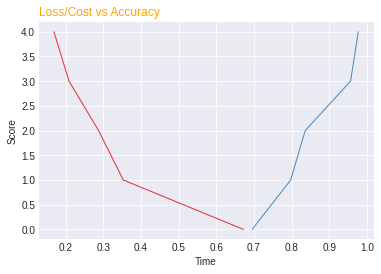

In [ ]:
def drawAUC(loss=[], accuracy=[]):
  # https://python-graph-gallery.com/124-spaghetti-plot/
  import matplotlib.pyplot as plt

  # style
  plt.style.use('seaborn-darkgrid')
  # create a color palette
  palette = plt.get_cmap('Set1')

  plt.plot(
      loss,
      [i for i in range(len(loss))],
      marker='',
      color=palette(0),
      linewidth=1,
      alpha=0.9,
      label="loss")
  
  plt.plot(
      accuracy,
      [i for i in range(len(accuracy))],
      marker='',
      color=palette(1),
      linewidth=1,
      alpha=0.9,
      label="accuracy")
  

  # Add titles
  plt.title("Loss/Cost vs Accuracy", loc='left', fontsize=12, fontweight=0, color='orange')
  plt.xlabel("Time")
  plt.ylabel("Score")


  # import seaborn as sns
  # sns.kdeplot(y=[i for i in range(len(loss))],
  #             x=loss)
  
  # sns.kdeplot(y=[i in range(len(loss))],
  #             x=accuracy)
  # sns.lineplot(x="timepoint", y="signal",
  #            hue="region", style="event",
  #            data=fmri)


drawAUC(loss, accuracy)

# Prediction sample

In [ ]:
cst_vgg_face.save_weights(f'cst_vgg_face-{SAMPLE_LABEL}.h5')
!ls -l cst_vgg_face*

In [ ]:
print(f'Sample record of people who are associated with SAMPLE_LABEL: {SAMPLE_LABEL}')
print('==============================')

SAMPLE = df[COLUMNS][df[COL_PERSON] == SAMPLE_LABEL].head(1)

Sample record of people who are associated with SAMPLE_LABEL: Jimmy Wales


SAMPLE[COL_VIDEO][1]: 257swlMMxmA
SAMPLE[COL_START][1]: 132
SAMPLE[COL_END][1]: 150
[youtube] 257swlMMxmA: Downloading webpage
[download] Destination: video.f136.mp4
[download] 100% of 58.38MiB in 00:00
[download] Destination: video.mp4.f251
[download] 100% of 4.71MiB in 00:00
[ffmpeg] Merging formats into "video.mkv"
Deleting original file video.f136.mp4 (pass -k to keep)
Deleting original file video.mp4.f251 (pass -k to keep)
['57swlMMxmA_001.bmp', '57swlMMxmA_002.bmp', '57swlMMxmA_003.bmp', '57swlMMxmA_004.bmp', '57swlMMxmA_005.bmp', '57swlMMxmA_006.bmp', '57swlMMxmA_007.bmp', '57swlMMxmA_008.bmp', '57swlMMxmA_009.bmp', '57swlMMxmA_010.bmp', '57swlMMxmA_011.bmp', '57swlMMxmA_012.bmp', '57swlMMxmA_013.bmp', '57swlMMxmA_014.bmp', '57swlMMxmA_015.bmp', '57swlMMxmA_016.bmp', '57swlMMxmA_017.bmp', '57swlMMxmA_018.bmp']


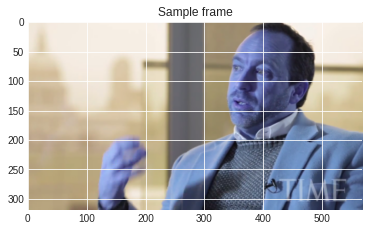

prediction: 0.6458635330200195%


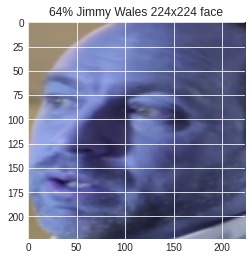

SAMPLE[COL_VIDEO][0]: uFMMXRoSxnA
SAMPLE[COL_START][0]: 571
SAMPLE[COL_END][0]: 590
[youtube] RHYNYuhkJ7Y: Downloading webpage
[download] Destination: video.f137.mp4
[download] 100% of 145.91MiB in 00:02
[download] Destination: video.mp4.f140
[download] 100% of 7.37MiB in 00:00
[ffmpeg] Merging formats into "video.mp4"
Deleting original file video.f137.mp4 (pass -k to keep)
Deleting original file video.mp4.f140 (pass -k to keep)
['001.bmp', '002.bmp']


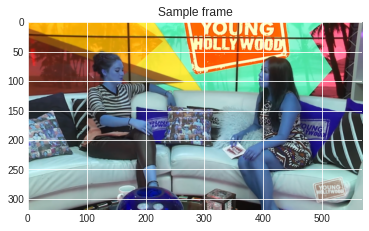

prediction: 0.013731447979807854%


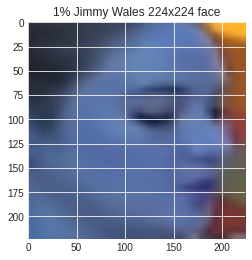

In [ ]:
def predectSample(model, YOUTUBE_VIDEO_ID, start_time, end_time):
    image_files = getImagesByVideoId(
                        YOUTUBE_VIDEO_ID=SAMPLE[COL_VIDEO].tolist()[1],
                        start_time= SAMPLE[COL_START].tolist()[1],
                        end_time= SAMPLE[COL_END].tolist()[1],
                        debug=False)
    print(image_files)

    # https://gist.github.com/mstfldmr/45d6e47bb661800b982c39d30215bc88
    import cv2

    img = cv2.imread(image_files[0])
    displayImageMatrix(matrix=img, title=f'Sample frame')

    bx, fc = getDNNFacesFromBGRMatrix(bgrMatrix=img,
                                  path_prefix= "sample",
                                  debug=False)
    # print(f'Face (x, y, x2, y2): {bx}')
    # displayImageMatrix(matrix=fc[0], title=f'{SAMPLE_LABEL} face')

    from cv2 import resize
    from tensorflow import convert_to_tensor
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
    from tensorflow.keras.applications.vgg16 import preprocess_input
    x = preprocess_input(resize(fc[0], (224, 224)))
    prediction = cst_vgg_face.predict(convert_to_tensor([x]))[0][1]
    print(f'prediction: {prediction}%')

    from cv2 import resize
    displayImageMatrix(matrix=resize(fc[0], (224, 224)),
                      title=f'{int(prediction*100)}% {SAMPLE_LABEL} 224x224 face')


SAMPLE = df[COLUMNS][df[COL_PERSON] == SAMPLE_LABEL]
print(f'SAMPLE[COL_VIDEO][1]: {SAMPLE[COL_VIDEO].tolist()[1]}')
print(f'SAMPLE[COL_START][1]: {SAMPLE[COL_START].tolist()[1]}')
print(f'SAMPLE[COL_END][1]: {SAMPLE[COL_END].tolist()[1]}')
predectSample(model=cst_vgg_face,
            YOUTUBE_VIDEO_ID=SAMPLE[COL_VIDEO].tolist()[1],
            start_time= SAMPLE[COL_START].tolist()[1],
            end_time= SAMPLE[COL_END].tolist()[1])
# =======================================================

SAMPLE = df[COLUMNS][df[COL_PERSON] != SAMPLE_LABEL]
print(f'SAMPLE[COL_VIDEO][0]: {SAMPLE[COL_VIDEO][0]}')
print(f'SAMPLE[COL_START][0]: {SAMPLE[COL_START][0]}')
print(f'SAMPLE[COL_END][0]: {SAMPLE[COL_END][0]}')
predectSample(model=cst_vgg_face,
            YOUTUBE_VIDEO_ID=SAMPLE[COL_VIDEO].tolist()[1],
            start_time= SAMPLE[COL_START].tolist()[1],
            end_time= SAMPLE[COL_END].tolist()[1])